In [1]:
# !pip install pixiedust git+https://github.com/Kings-Distributed-Systems/pixiedust_node#egg=pixiedust_node

In [1]:
# import pixiedust
# import pixiedust_node
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [3]:
# ID_KEY_LOC = '/home/mgasmallah/DCP/keys/id.keystore'
# ACC_KEY_LOC= '/home/mgasmallah/DCP/keys/AISTEST.keystore'
# SCHEDULER  = 'https://scheduler.distributed.computer'

# node.clear();
# !job-utility cancelAllJobs -I $ID_KEY_LOC --default-bank-account-file $ACC_KEY_LOC --scheduler $SCHEDULER
# npm.install( 'dcp-client' )

In [4]:
# %%node

# process.argv.push('-I', ID_KEY_LOC, '--default-bank-account-file', ACC_KEY_LOC, '--scheduler', SCHEDULER)
# require('dcp-client').initSync(process.argv)
# const compute = require('dcp/compute');
# const wallet = require('dcp/wallet');
# const dcpCli = require('dcp/dcp-cli');

# var accountKeystore;
# var identityKeystore;

# (async function(){
#     identityKeystore = await dcpCli.getIdentityKeystore();
#     wallet.addId(identityKeystore);
#     accountKeystore = await dcpCli.getAccountKeystore();
#     console.log("Keystores loaded!");
# })();

In [2]:
(_xtrain, _ytrain), (_xtest, _ytest) = tf.keras.datasets.cifar10.load_data()
_xtrain = _xtrain.astype(np.float32) / 255.
_xtest  = _xtest.astype(np.float32)  / 255.
print(_xtrain.min(), _xtrain.max(), _xtrain.dtype, _xtrain.shape)

0.0 1.0 float32 (50000, 32, 32, 3)


In [6]:
class Encoder(tf.keras.Model):
    def __init__(self, latent_dims=10):
        super(Encoder, self).__init__()
        self.latent_dims = latent_dims
        self.ls = [
            tf.keras.layers.Conv2D(3, [3,3], strides=[1,1], padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64,[3,3],strides=[2,2], padding='same', activation='relu'),
            tf.keras.layers.Conv2D(128,[3,3],strides=[2,2], padding='same', activation='relu'),
            tf.keras.layers.Conv2D(256, [1,1], strides=[2,2], padding='same', activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.latent_dims * 2, activation='linear')
        ]
    
    def call(self, x):
        for l in self.ls:
            x = l(x)
        return x

class Reparameterize(tf.keras.layers.Layer):
    def __init__(self):
        super(Reparameterize, self).__init__()
        def sample(args):
            z_mean, z_log_var = args
            eps = tf.random.normal(shape=tf.shape(z_mean), mean=0.)
            return z_mean + tf.exp(z_log_var) * eps
        self.l = tf.keras.layers.Lambda(
            sample
        )
        
    def call(self, mean, logvar):
        return self.l([mean, logvar])

class Decoder(tf.keras.Model):
    def __init__(self, latent_dims=10):
        super(Decoder, self).__init__()
        self.latent_dims = latent_dims
        self.ls = [
            tf.keras.layers.Dense(self.latent_dims*2, activation='relu'),
            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Reshape([4,4,256]),
            tf.keras.layers.Conv2DTranspose(256, [3,3], strides=[2,2], padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(128, [3,3], strides=[2,2], padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(64, [3,3], strides=[2,2], padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(3, [3,3], strides=[1,1], padding='same', activation='linear'),
        ]
    def call(self, x):
        for l in self.ls:
            x = l(x)
        return x
        

In [7]:
# e = Encoder()
# r = Reparameterize()
# d = Decoder()

In [8]:
# print(_xtrain[0:1].shape)
# _o = e(_xtrain[0:1,...])
# _mean, _logvar = tf.split(_o, 2, axis=-1)
# print(_mean.shape)
# _oo = r(_mean, _logvar)
# # print(_oo.shape)
# _ooo = d(_oo)
# print(_ooo.shape)

In [9]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dims=10):
        super(VAE, self).__init__()
        
        self.latent_dims = latent_dims
        self.encoder = Encoder(self.latent_dims)
        self.reparameterizer = Reparameterize()
        self.decoder = Decoder(self.latent_dims)
    
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = tf.split(x, 2, axis=1)
        return mean, logvar
    
    def decode(self,z):
        return self.decoder(z)
    
    def log_normal_pdf(self,sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample-mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)
    
    def vae_loss(self,x_true, x_pred_logit, mean, logvar, z):
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_pred_logit, labels=x_true)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)
        return - tf.reduce_mean(logpx_z + logpz - logqz_x)
    
    def call(self,x):
        mean, logvar = self.encode(x)
        z = self.reparameterizer(mean, logvar)
        x_logit = self.decode(z)
        loss = self.vae_loss(x, x_logit, mean, logvar, z)
        self.add_loss(loss, inputs=x)
        return x_logit

In [10]:
vae = VAE(512)

vae(_xtrain[0:10,...]).shape

TensorShape([10, 32, 32, 3])

In [11]:
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  4304084   
_________________________________________________________________
reparameterize (Reparameteri multiple                  0         
_________________________________________________________________
decoder (Decoder)            multiple                  5684355   
Total params: 9,988,439
Trainable params: 9,988,439
Non-trainable params: 0
_________________________________________________________________


In [12]:
_history = vae.fit(_xtrain, 
                  shuffle=True,
                  epochs = 100,
                  batch_size=512,
                  validation_data=(_xtest, None),
                   callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
98/98 [==============================] - 11s 109ms/step - loss: 2095.3679 - val_loss: 2051.2925
Epoch 2/100
98/98 [==============================] - 10s 101ms/step - loss: 2028.8777 - val_loss: 2019.6409
Epoch 3/100
98/98 [==============================] - 10s 101ms/step - loss: 2011.0162 - val_loss: 2019.6761
Epoch 4/100
98/98 [==============================] - 10s 102ms/step - loss: 1986.1572 - val_loss: 2020.0950
Epoch 5/100
98/98 [==============================] - 10s 102ms/step - loss: 1971.0948 - val_loss: 1984.9238
Epoch 6/100
98/98 [==============================] - 10s 103ms/step - loss: 1957.7103 - val_loss: 1943.7986
Epoch 7/100
98/98 [==============================] - 10s 104ms/step - loss: 1947.6562 - val_loss: 1934.1136
Epoch 8/100
98/98 [==============================] - 10s 104ms/step - loss: 1940.6704 - val_loss: 1955.6699
Epoch 9/100
98/98 [==============================] - 10s 104ms/step - loss: 1932.5580 - val_loss: 1917.8518
Epoch 10/100
98/98 [========

{'loss': [2095.367919921875, 2028.877685546875, 2011.0162353515625, 1986.1572265625, 1971.0948486328125, 1957.7103271484375, 1947.65625, 1940.67041015625, 1932.5579833984375, 1924.151611328125, 1916.845458984375, 1909.7618408203125, 1903.068359375, 1895.98388671875, 1890.6644287109375, 1886.0501708984375, 1882.1678466796875, 1878.692626953125, 1876.095458984375, 1873.607177734375, 1870.4229736328125, 1867.1837158203125, 1865.4102783203125, 1863.3035888671875, 1861.8907470703125, 1860.052001953125, 1857.5118408203125, 1856.1397705078125, 1853.8782958984375, 1852.5394287109375, 1850.8162841796875, 1849.06396484375, 1847.5191650390625, 1846.373779296875, 1845.0279541015625, 1843.7076416015625, 1842.9854736328125, 1841.48388671875, 1840.020751953125, 1839.7503662109375, 1838.6197509765625, 1838.0665283203125, 1837.0771484375, 1836.4654541015625, 1835.9420166015625, 1835.247314453125, 1834.5802001953125, 1833.88232421875, 1833.3355712890625, 1832.7337646484375, 1832.0333251953125, 1831.1650

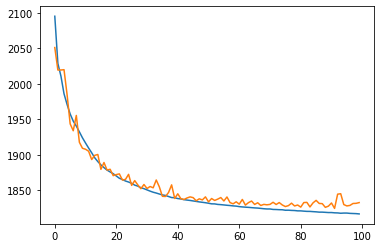

In [13]:
print(_history.history)
plt.plot(_history.history['loss'])
plt.plot(_history.history['val_loss'])

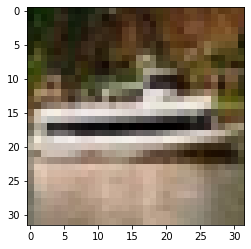

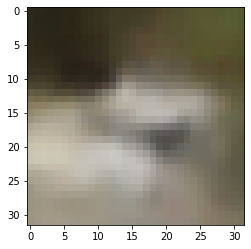

In [28]:
randInt = np.random.randint(0,_xtest.shape[0])
plt.imshow(_xtest[randInt])
plt.show()
plt.imshow(tf.nn.sigmoid(vae(_xtest[randInt:randInt+1])).numpy()[0])
plt.show()

In [20]:
vae.save('./vae', save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./vae/assets


In [21]:
from google.colab import files

In [22]:
!zip -r vae.zip ./vae

  adding: vae/ (stored 0%)
  adding: vae/saved_model.pb (deflated 88%)
  adding: vae/variables/ (stored 0%)
  adding: vae/variables/variables.data-00000-of-00001 (deflated 22%)
  adding: vae/variables/variables.index (deflated 70%)
  adding: vae/assets/ (stored 0%)


In [23]:
files.download('vae.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
model = tf.saved_model.load('./vae')

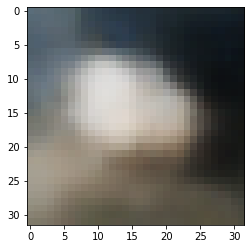

In [50]:
out = tf.nn.sigmoid(model.decoder(tf.random.normal([1,512]))).numpy()[0]
plt.imshow(out)
plt.show()